In [1]:
#Imports
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from PIL import Image
import cv2
import os
from tqdm import tqdm
from random import shuffle
import time
import math
from datetime import timedelta
from tensorflow.contrib.layers import dropout

In [2]:
from nnfunc import *
from myfunc import *

In [3]:
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return [0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [1]

In [4]:
# Create the data for the images and labels and save it into a .npy file
def create_data():
    data = [] 
    
    for img in tqdm(os.listdir(DATA_DIR)):
        label = label_img(img)
        path = os.path.join(DATA_DIR, img)
        img = Image.open(path)
        img = np.array(img)
        img = cv2.resize(img, (IMG_SIZE_PREPRO, IMG_SIZE_PREPRO))
        data.append([np.array(img), np.array(label)])

    shuffle(data)
    np.save(SAVED_DATA_FILE, data)

In [5]:
def split_image_label(data):
    images = np.array([i[0] for i in data]).reshape(-1,IMG_SIZE_PREPRO,IMG_SIZE_PREPRO, NB_CHANNELS)
    labels = np.array([i[1] for i in data])
    return images, labels

In [6]:
def augmented_train_image(image):
    # Randomly crop the input image.
    image = tf.random_crop(image, size=[IMG_SIZE, IMG_SIZE, NB_CHANNELS])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image, max_delta=0.05)
    image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_saturation(image, lower=0.0, upper=2.0)
    
    # Limit the image pixels between [0, 1] in case of overflow.
    image = tf.minimum(image, 1.0)
    image = tf.maximum(image, 0.0)
    
    return image

In [7]:
def augmented_test_image(image):
    # Crop the input image around the centre so it is the same
    # size as images that are randomly cropped during training.
    image = tf.image.resize_image_with_crop_or_pad(image,
                                                   target_height=IMG_SIZE,
                                                   target_width=IMG_SIZE)
    return image

In [8]:
def pre_process_images(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = tf.cond(training, 
                     lambda: tf.map_fn(lambda image: augmented_train_image(image), images),
                     lambda: tf.map_fn(lambda image: augmented_test_image(image), images))

    return images

In [9]:
def optimize(epoch, train_images, train_labels, batch_size=64):
    # Total number of batches in our training set.
    nb_batches = int(np.ceil(len(train_images)/batch_size))
    start_time = time.time()
    nb_past_steps = session.run(global_step)

    for i in range(nb_past_steps, nb_past_steps + epoch):
        # Get a batch of training examples to feed and run the optimizer
        current_batch_index = i % nb_batches
        x_batch, y_true_batch = fetch_batch(train_images, train_labels, 
                                            batch_size, current_batch_index)
        feed_dict_train = {x: x_batch, y_true: y_true_batch, training: True}
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 99:
            current_acc = session.run(accuracy, feed_dict=feed_dict_train)
            current_loss = session.run(loss, feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0}, Training Accuracy: {1:.1%}, Training Loss: {2}"
            print(msg.format(i + 1, current_acc, current_loss))
 
    #Time used 
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [10]:
# Print the testing accuracy
def testing_accuracy(test_images, test_labels, batch_size=64, confusion_matrix=False, example_errors=False):
    # Number of images in the test-set
    nb_test = len(test_images)
    
    #Array to store the predicted classes for each test image
    cls_pred = np.zeros(shape=(nb_test,1), dtype=np.int)
    
    # Total number of batches in our testing set.
    nb_batches = int(np.ceil(nb_test/batch_size))
    
    for i in tqdm(range(0, nb_batches)):
        x_batch, y_true_batch = fetch_batch(test_images, test_labels, batch_size, i)
        feed_dict = {x: x_batch, y_true: y_true_batch, training: False}
        
        # Calculate the predicted class for each test image
        cls_pred[(i*batch_size):min((i*batch_size+batch_size), nb_test)] = session.run(y_pred_cls, feed_dict=feed_dict)
        
    #cls_pred = np.array([[i] for i in cls_pred])
    correct = (test_labels == cls_pred)
    correct_sum = correct.sum()
    test_acc = float(correct_sum) / nb_test    
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(test_acc, correct_sum, nb_test))
    
    if confusion_matrix:
        plot_confusion_matrix(cls_pred, test_labels)
    if example_errors:
        plot_example_errors(test_images, test_labels, cls_pred)

In [11]:
# Test the model on one image
def test_one_image(image, label, altered=False):
    feed_dict = {x: [image], y_true: [label], training: altered}
    pred = session.run(y_pred, feed_dict=feed_dict)
    augmented_image = session.run(aug_images, feed_dict=feed_dict).reshape(IMG_SIZE,IMG_SIZE, NB_CHANNELS)
    plot_image(augmented_image, label, pred)

In [ ]:
def augmented_train_image(image):
    # Randomly crop the input image.
    image = tf.random_crop(image, size=[IMG_SIZE, IMG_SIZE, NB_CHANNELS])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image, max_delta=0.05)
    image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_saturation(image, lower=0.0, upper=2.0)
    
    # Limit the image pixels between [0, 1] in case of overflow.
    image = tf.minimum(image, 1.0)
    image = tf.maximum(image, 0.0)
    
    return image

In [ ]:
def augmented_test_image(image):
    # Crop the input image around the centre so it is the same
    # size as images that are randomly cropped during training.
    image = tf.image.resize_image_with_crop_or_pad(image,
                                                   target_height=IMG_SIZE,
                                                   target_width=IMG_SIZE)
    return image

In [ ]:
def pre_process_images(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = tf.cond(training, 
                     lambda: tf.map_fn(lambda image: augmented_train_image(image), images),
                     lambda: tf.map_fn(lambda image: augmented_test_image(image), images))

    return images

In [12]:
# Constant values 128-112, 64-60
DATA_DIR = 'train/train'
SAVED_DATA_FILE = 'binarydata128.npy'
BATCH_SIZE = 64
IMG_SIZE_PREPRO = 128
IMG_SIZE = 112
NB_CHANNELS = 3
GREYSCALE = False
LR = 1e-4

In [13]:
# Take the images from the folder, extract the label, same all the samples into a .npy file
#create_data()

100%|███████████████████████████████████████████████████████████████████████████| 25041/25041 [01:24<00:00, 294.78it/s]


In [14]:
# Load the data from the .npy file
data = np.load(SAVED_DATA_FILE)

In [ ]:
train = data[:20000]
test = data[20000:]

In [16]:
# Separating images and labels
train_images, train_labels = split_image_label(train)
test_images, test_labels = split_image_label(test)

In [17]:
# Values of each pixel in 0-1
train_images = train_images/255
test_images = test_images/255

True: [1]


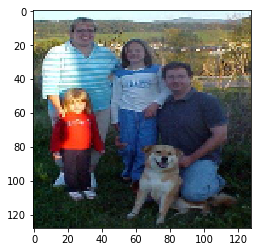

In [18]:
num = 6
plot_image(train_images[num], train_labels[num])

In [19]:
x = tf.placeholder(tf.float32, shape=[None, IMG_SIZE_PREPRO, IMG_SIZE_PREPRO, NB_CHANNELS], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, 1], name='y_true')
training = tf.placeholder(tf.bool)
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)

In [20]:
#Data augmentation
aug_images = pre_process_images(images=x, training=training)

#CNN
layer_conv1 = conv_2d(aug_images, NB_CHANNELS, 5, 32, use_pooling=True)
layer_conv2 = conv_2d(layer_conv1, 32, 5, 32, use_pooling=True)
layer_conv3 = conv_2d(layer_conv2, 32, 5, 32, use_pooling=True)
layer_conv4 = conv_2d(layer_conv3, 32, 5, 32, use_pooling=True)
layer_conv5 = conv_2d(layer_conv4, 32, 5, 32, use_pooling=True)
layer_conv6 = conv_2d(layer_conv5, 32, 5, 32, use_pooling=True)
layer_conv7 = conv_2d(layer_conv6, 32, 5, 32, use_pooling=True)
layer_conv8 = conv_2d(layer_conv7, 32, 5, 32, use_pooling=True)


#FCNN
layer_flat, num_features = flatten_layer(layer_conv8)
layer_fc1 = fc_layer(layer_flat, num_features, 256, use_relu=True)
layer_fc2 = fc_layer(dropout(layer_fc1, 0.2), 256, 256, use_relu=True)
layer_fc3 = fc_layer(dropout(layer_fc2, 0.2), 256, 256, use_relu=True)
layer_fc4 = fc_layer(dropout(layer_fc3, 0.2), 256, 1, use_relu=False)

#prediction
y_pred = tf.nn.sigmoid(layer_fc4)
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=layer_fc4, labels=y_true)
loss = tf.reduce_mean(cross_entropy)

In [21]:
#optimization
optimizer = tf.train.AdamOptimizer(learning_rate=LR).minimize(loss, global_step=global_step)

In [22]:
# Performance measures for testing
y_pred_cls = tf.round(y_pred)
correct_prediction = tf.equal(y_pred_cls, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [23]:
#session
saver = tf.train.Saver()
session = tf.Session()
session.run(tf.global_variables_initializer())

In [29]:
for i in range(10):
    optimize(1000, train_images, train_labels, BATCH_SIZE)
    testing_accuracy(test_images, test_labels, BATCH_SIZE)

Optimization Iteration: 100, Training Accuracy: 42.2%, Training Loss: 0.6591542363166809
Optimization Iteration: 200, Training Accuracy: 60.9%, Training Loss: 0.6423037648200989
Optimization Iteration: 300, Training Accuracy: 65.6%, Training Loss: 0.6488697528839111
Optimization Iteration: 400, Training Accuracy: 71.9%, Training Loss: 0.5975142121315002
Optimization Iteration: 500, Training Accuracy: 70.3%, Training Loss: 0.5331339836120605
Optimization Iteration: 600, Training Accuracy: 70.3%, Training Loss: 0.6330892443656921
Optimization Iteration: 700, Training Accuracy: 73.4%, Training Loss: 0.5194666385650635
Optimization Iteration: 800, Training Accuracy: 75.0%, Training Loss: 0.5422254204750061
Optimization Iteration: 900, Training Accuracy: 65.6%, Training Loss: 0.5841243267059326
Optimization Iteration: 1000, Training Accuracy: 65.6%, Training Loss: 0.5714046955108643
Time usage: 1:01:47


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:51<00:00,  1.41s/it]


Accuracy on Test-Set: 69.4% (3497 / 5041)
Optimization Iteration: 1100, Training Accuracy: 67.2%, Training Loss: 0.5543756484985352
Optimization Iteration: 1200, Training Accuracy: 70.3%, Training Loss: 0.46615079045295715
Optimization Iteration: 1300, Training Accuracy: 65.6%, Training Loss: 0.5811851024627686
Optimization Iteration: 1400, Training Accuracy: 75.0%, Training Loss: 0.5529823303222656
Optimization Iteration: 1500, Training Accuracy: 79.7%, Training Loss: 0.5128844380378723
Optimization Iteration: 1600, Training Accuracy: 82.8%, Training Loss: 0.46244609355926514
Optimization Iteration: 1700, Training Accuracy: 79.7%, Training Loss: 0.43823954463005066
Optimization Iteration: 1800, Training Accuracy: 79.7%, Training Loss: 0.38666942715644836
Optimization Iteration: 1900, Training Accuracy: 79.7%, Training Loss: 0.45833295583724976
Optimization Iteration: 2000, Training Accuracy: 71.9%, Training Loss: 0.5444793105125427
Time usage: 1:00:26


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:45<00:00,  1.33s/it]


Accuracy on Test-Set: 79.1% (3988 / 5041)
Optimization Iteration: 2100, Training Accuracy: 78.1%, Training Loss: 0.4612484574317932
Optimization Iteration: 2200, Training Accuracy: 73.4%, Training Loss: 0.5056378841400146
Optimization Iteration: 2300, Training Accuracy: 79.7%, Training Loss: 0.5168108940124512
Optimization Iteration: 2400, Training Accuracy: 79.7%, Training Loss: 0.40216851234436035
Optimization Iteration: 2500, Training Accuracy: 65.6%, Training Loss: 0.5422564744949341
Optimization Iteration: 2600, Training Accuracy: 79.7%, Training Loss: 0.4016193747520447
Optimization Iteration: 2700, Training Accuracy: 84.4%, Training Loss: 0.38610735535621643
Optimization Iteration: 2800, Training Accuracy: 82.8%, Training Loss: 0.3842337131500244
Optimization Iteration: 2900, Training Accuracy: 79.7%, Training Loss: 0.39390480518341064
Optimization Iteration: 3000, Training Accuracy: 78.1%, Training Loss: 0.5178918838500977
Time usage: 0:59:33


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:44<00:00,  1.33s/it]


Accuracy on Test-Set: 81.1% (4086 / 5041)
Optimization Iteration: 3100, Training Accuracy: 75.0%, Training Loss: 0.45097604393959045
Optimization Iteration: 3200, Training Accuracy: 89.1%, Training Loss: 0.275187611579895
Optimization Iteration: 3300, Training Accuracy: 75.0%, Training Loss: 0.3265568017959595
Optimization Iteration: 3400, Training Accuracy: 75.0%, Training Loss: 0.444610595703125
Optimization Iteration: 3500, Training Accuracy: 79.7%, Training Loss: 0.4343588650226593
Optimization Iteration: 3600, Training Accuracy: 81.2%, Training Loss: 0.3710029721260071
Optimization Iteration: 3700, Training Accuracy: 76.6%, Training Loss: 0.38006824254989624
Optimization Iteration: 3800, Training Accuracy: 81.2%, Training Loss: 0.3035581707954407
Optimization Iteration: 3900, Training Accuracy: 82.8%, Training Loss: 0.43200674653053284
Optimization Iteration: 4000, Training Accuracy: 82.8%, Training Loss: 0.402757853269577
Time usage: 0:41:06


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:55<00:00,  1.43it/s]


Accuracy on Test-Set: 84.2% (4245 / 5041)
Optimization Iteration: 4100, Training Accuracy: 81.2%, Training Loss: 0.40281039476394653
Optimization Iteration: 4200, Training Accuracy: 76.6%, Training Loss: 0.4472050964832306
Optimization Iteration: 4300, Training Accuracy: 85.9%, Training Loss: 0.31663304567337036
Optimization Iteration: 4400, Training Accuracy: 81.2%, Training Loss: 0.4637327790260315
Optimization Iteration: 4500, Training Accuracy: 85.9%, Training Loss: 0.3428821563720703
Optimization Iteration: 4600, Training Accuracy: 85.9%, Training Loss: 0.262320876121521
Optimization Iteration: 4700, Training Accuracy: 87.5%, Training Loss: 0.2750028967857361
Optimization Iteration: 4800, Training Accuracy: 79.7%, Training Loss: 0.5520465970039368
Optimization Iteration: 4900, Training Accuracy: 76.6%, Training Loss: 0.4151851534843445
Optimization Iteration: 5000, Training Accuracy: 85.9%, Training Loss: 0.36739808320999146
Time usage: 0:35:02


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:47<00:00,  1.65it/s]


Accuracy on Test-Set: 86.1% (4340 / 5041)
Optimization Iteration: 5100, Training Accuracy: 85.9%, Training Loss: 0.3483737111091614
Optimization Iteration: 5200, Training Accuracy: 81.2%, Training Loss: 0.2822518050670624
Optimization Iteration: 5300, Training Accuracy: 90.6%, Training Loss: 0.26630914211273193
Optimization Iteration: 5400, Training Accuracy: 76.6%, Training Loss: 0.5266000032424927
Optimization Iteration: 5500, Training Accuracy: 87.5%, Training Loss: 0.3286606967449188
Optimization Iteration: 5600, Training Accuracy: 82.8%, Training Loss: 0.30495738983154297
Optimization Iteration: 5700, Training Accuracy: 87.5%, Training Loss: 0.32350948452949524
Optimization Iteration: 5800, Training Accuracy: 89.1%, Training Loss: 0.23532317578792572
Optimization Iteration: 5900, Training Accuracy: 85.9%, Training Loss: 0.40350842475891113
Optimization Iteration: 6000, Training Accuracy: 85.9%, Training Loss: 0.3226841688156128
Time usage: 0:35:00


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:48<00:00,  1.64it/s]


Accuracy on Test-Set: 88.2% (4448 / 5041)
Optimization Iteration: 6100, Training Accuracy: 89.1%, Training Loss: 0.32892513275146484
Optimization Iteration: 6200, Training Accuracy: 85.9%, Training Loss: 0.35843515396118164
Optimization Iteration: 6300, Training Accuracy: 92.2%, Training Loss: 0.1630425751209259
Optimization Iteration: 6400, Training Accuracy: 89.1%, Training Loss: 0.21859246492385864
Optimization Iteration: 6500, Training Accuracy: 93.8%, Training Loss: 0.19276532530784607
Optimization Iteration: 6600, Training Accuracy: 90.6%, Training Loss: 0.30919402837753296
Optimization Iteration: 6700, Training Accuracy: 82.8%, Training Loss: 0.28975504636764526
Optimization Iteration: 6800, Training Accuracy: 85.9%, Training Loss: 0.17889517545700073
Optimization Iteration: 6900, Training Accuracy: 95.3%, Training Loss: 0.24038225412368774
Optimization Iteration: 7000, Training Accuracy: 87.5%, Training Loss: 0.23980017006397247
Time usage: 0:35:03


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:48<00:00,  1.64it/s]


Accuracy on Test-Set: 87.4% (4408 / 5041)
Optimization Iteration: 7100, Training Accuracy: 90.6%, Training Loss: 0.19060209393501282
Optimization Iteration: 7200, Training Accuracy: 87.5%, Training Loss: 0.30445951223373413
Optimization Iteration: 7300, Training Accuracy: 92.2%, Training Loss: 0.26937171816825867
Optimization Iteration: 7400, Training Accuracy: 90.6%, Training Loss: 0.23580434918403625
Optimization Iteration: 7500, Training Accuracy: 96.9%, Training Loss: 0.15922677516937256
Optimization Iteration: 7600, Training Accuracy: 85.9%, Training Loss: 0.18208277225494385
Optimization Iteration: 7700, Training Accuracy: 90.6%, Training Loss: 0.22797787189483643
Optimization Iteration: 7800, Training Accuracy: 79.7%, Training Loss: 0.3516102433204651
Optimization Iteration: 7900, Training Accuracy: 89.1%, Training Loss: 0.20532965660095215
Optimization Iteration: 8000, Training Accuracy: 87.5%, Training Loss: 0.36441394686698914
Time usage: 0:35:05


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:47<00:00,  1.65it/s]


Accuracy on Test-Set: 90.0% (4535 / 5041)
Optimization Iteration: 8100, Training Accuracy: 92.2%, Training Loss: 0.28305524587631226
Optimization Iteration: 8200, Training Accuracy: 90.6%, Training Loss: 0.2726493775844574
Optimization Iteration: 8300, Training Accuracy: 90.6%, Training Loss: 0.2384846806526184
Optimization Iteration: 8400, Training Accuracy: 92.2%, Training Loss: 0.2523631751537323
Optimization Iteration: 8500, Training Accuracy: 90.6%, Training Loss: 0.16605032980442047
Optimization Iteration: 8600, Training Accuracy: 89.1%, Training Loss: 0.22474515438079834
Optimization Iteration: 8700, Training Accuracy: 87.5%, Training Loss: 0.2979266047477722
Optimization Iteration: 8800, Training Accuracy: 85.9%, Training Loss: 0.3402387499809265
Optimization Iteration: 8900, Training Accuracy: 89.1%, Training Loss: 0.17116199433803558
Optimization Iteration: 9000, Training Accuracy: 89.1%, Training Loss: 0.14553028345108032
Time usage: 0:48:43


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:43<00:00,  1.31s/it]


Accuracy on Test-Set: 89.4% (4506 / 5041)
Optimization Iteration: 9100, Training Accuracy: 92.2%, Training Loss: 0.1491999626159668
Optimization Iteration: 9200, Training Accuracy: 90.6%, Training Loss: 0.20052732527256012
Optimization Iteration: 9300, Training Accuracy: 89.1%, Training Loss: 0.18310502171516418
Optimization Iteration: 9400, Training Accuracy: 93.8%, Training Loss: 0.20069937407970428
Optimization Iteration: 9500, Training Accuracy: 89.1%, Training Loss: 0.20941317081451416
Optimization Iteration: 9600, Training Accuracy: 96.9%, Training Loss: 0.13576899468898773
Optimization Iteration: 9700, Training Accuracy: 93.8%, Training Loss: 0.13380904495716095
Optimization Iteration: 9800, Training Accuracy: 90.6%, Training Loss: 0.18545430898666382
Optimization Iteration: 9900, Training Accuracy: 90.6%, Training Loss: 0.16747811436653137
Optimization Iteration: 10000, Training Accuracy: 93.8%, Training Loss: 0.16755428910255432
Time usage: 0:59:28


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:46<00:00,  1.35s/it]


Accuracy on Test-Set: 90.0% (4537 / 5041)


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:50<00:00,  1.55it/s]


Accuracy on Test-Set: 91.6% (4617 / 5041)
[[2289  182]
 [ 242 2328]]


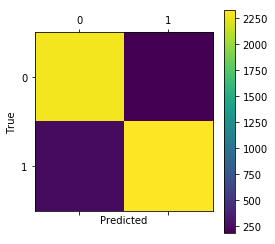

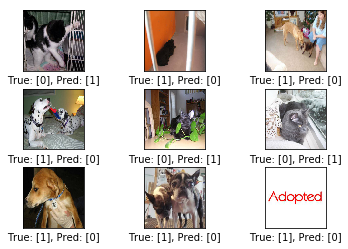

In [33]:
# Testing
testing_accuracy(test_images, test_labels, BATCH_SIZE, confusion_matrix=True, example_errors=True)

True: [1], Pred: [[0.99999833]]


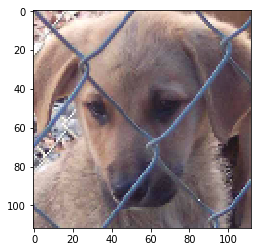

In [35]:
num = 8
image = test_images[num]
label = test_labels[num]
test_one_image(image, label, False)

In [38]:
# Restore model
saver.restore(session, 'saved_model/first_try')

INFO:tensorflow:Restoring parameters from saved_model/classification_64p_32c_1024f_3k_color_allpix_4conv-50000


In [41]:
# Save model
saver.save(session, 'saved_model/classification_75p_32c_1024f_3k_color_allpix_2conv', global_step=global_step)

'saved_model/classification_75p_32c_1024f_3k_color_allpix_2conv-0'